# pfceval | Basic evaluation template

This notebooks shows how to do a basic evaluation for two psudo forecasts.

### Prepare Evaluation reports

In [3]:
import pfceval
import polars as pl

from dataclasses import dataclass

@dataclass
class BasicEvalConfig():
    index_cols = ["valid_time", "station_id", "step"]
    eval_ths = [9, 12]
    save_dir = "."
    lead_time_col = "step"
    location_id_col = "station_id"
    ensemble_prefix = "pred_q"
    obs_col = "wind_speed"
    bootstrap_col = "run_id"
    n_bootstrap_iter = 10
    CI = 0.9

    construct_eval_reports = True

config = BasicEvalConfig()


def get_basic_evaluation_report(forecast, experiment_name):

    calc = pfceval.Calculator(forecast, config.index_cols)
    calc.add_absolute_error()
    calc.add_squared_error()
    # Add probabilistic metrics
    calc.add_spread()
    calc.add_crps()
    # Add threshold based metrics
    for th in config.eval_ths:
        calc.add_twcrps(th)
        calc.add_brier(th)

    # fill_evaluation is a quick way to create an Evaluation.
    # Custom evaluations also can be done without using it.
    report = pfceval.Evaluation.fill_evaluation(
        experiment_name=experiment_name,
        calculator=calc, 
        lead_time_col=config.lead_time_col,
        location_id_col=config.location_id_col,
        bootstrap=True, 
        n_iter=config.n_bootstrap_iter, 
        CI=config.CI,
        location_metrics=True,
    )

    return report

# Generate psudo forecasts
forecast_paths = pfceval.utils.get_example_forecast_paths()

exp_names = []
for i, forecast_path in enumerate(forecast_paths):
    forecast = pfceval.Forecast(
        fc_path=forecast_path,
        ensemble_prefix=config.ensemble_prefix,
        obs_col=config.obs_col,
        bootstrap_cols=config.bootstrap_col,
        load_to_memory=True
    )

    exp_name = f"BasicEvaluationTemplate_{i}"
    exp_names.append(exp_name)
    report = get_basic_evaluation_report(
        forecast=forecast, 
        experiment_name=exp_name
    )
    # Get metrics for the stations that is present in training data
    seen_report = get_basic_evaluation_report(
        forecast=forecast.filter(pl.col("unseen_sta") == False), 
        experiment_name=exp_name
    )
    # Get metrics for the stations that is not present the training data
    unseen_report = get_basic_evaluation_report(
        forecast=forecast.filter(pl.col("unseen_sta") == True), 
        experiment_name=exp_name
    )
    # Get a common report for all filters by combining them
    # The reports on right will have the right_prefix in their tables
    report.extend(seen_report, right_prefix="seen")
    report.extend(unseen_report, right_prefix="unseen")
    # Save the report to disk
    report.save_results(f"{config.save_dir}/{exp_name}")

### Load the evaluation reports and analyze 

In [4]:
### Wind speed dist: N(10, 3+step/5)
### BasicEvaluationTemplate_i pred dist: N(13-3*i, 5)

In [5]:
# Read reports from location
reports = [pfceval.Evaluation.load_report(f"./{path}") for path in exp_names]

overall = pfceval.plotting.stack_overall_metrics(*reports)
overall.sort("mae")

experiment,twcrps_th:12,brier_th:9,mse,mae,twcrps_th:9,spread,crps,brier_th:12
str,f64,f64,f64,f64,f64,f64,f64,f64
"""BasicEvaluationTemplate_1""",1.853887,0.25333,70.62439,6.276376,2.614827,4.96433,4.761594,0.247494
"""BasicEvaluationTemplate_0""",1.892454,0.303856,74.370019,6.699166,2.791339,4.993339,5.045261,0.278893


In [6]:
unseen_overall = pfceval.plotting.stack_overall_metrics(*reports, table_name="unseen_overall_metrics")
unseen_overall.sort("mae")

experiment,twcrps_th:12,brier_th:9,mse,mae,twcrps_th:9,spread,crps,brier_th:12
str,f64,f64,f64,f64,f64,f64,f64,f64
"""BasicEvaluationTemplate_1""",1.856897,0.24978,67.684864,6.162836,2.621503,4.968771,4.665804,0.249611
"""BasicEvaluationTemplate_0""",1.974588,0.308178,73.604663,6.766729,2.876041,4.983898,5.07577,0.278087


In [7]:
seen_overall = pfceval.plotting.stack_overall_metrics(*reports, table_name="seen_overall_metrics")
seen_overall.sort("mae")

experiment,twcrps_th:12,brier_th:9,mse,mae,twcrps_th:9,spread,crps,brier_th:12
str,f64,f64,f64,f64,f64,f64,f64,f64
"""BasicEvaluationTemplate_1""",1.851881,0.255696,72.584073,6.35207,2.610376,4.96137,4.825454,0.246083
"""BasicEvaluationTemplate_0""",1.837698,0.300975,74.880256,6.654124,2.734872,4.999633,5.024922,0.279431


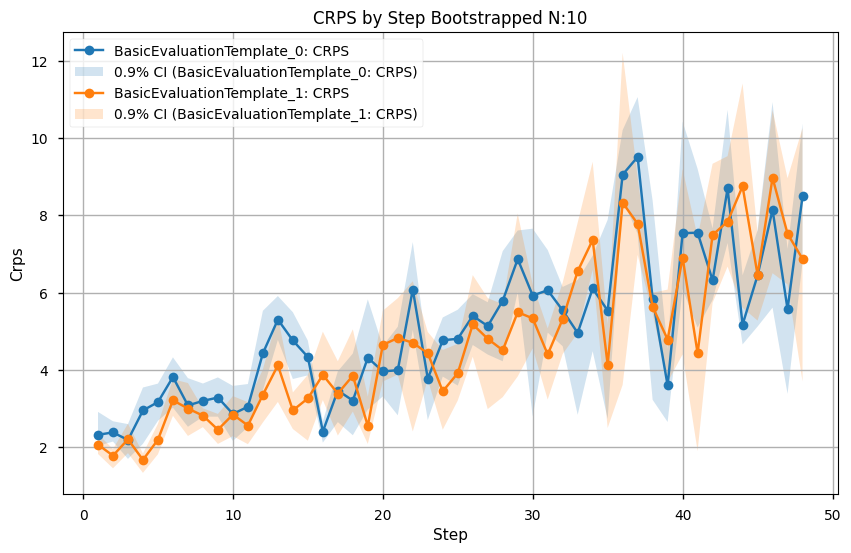

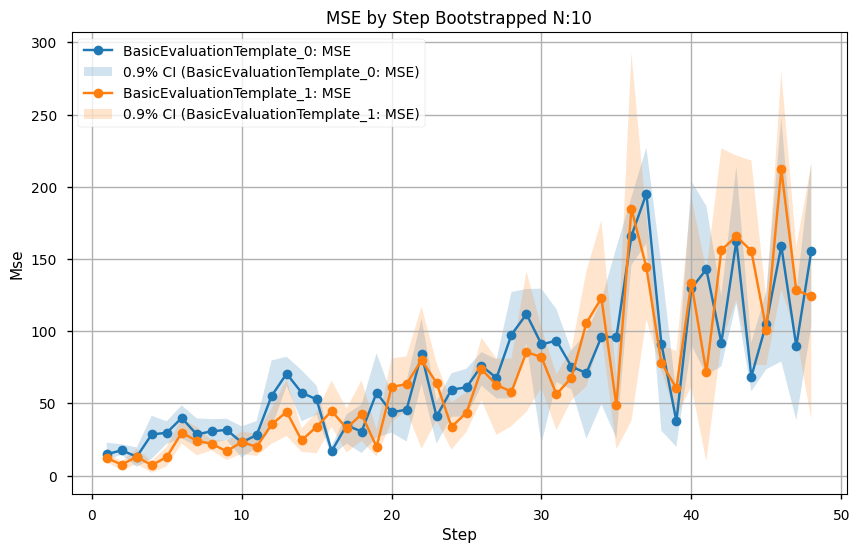

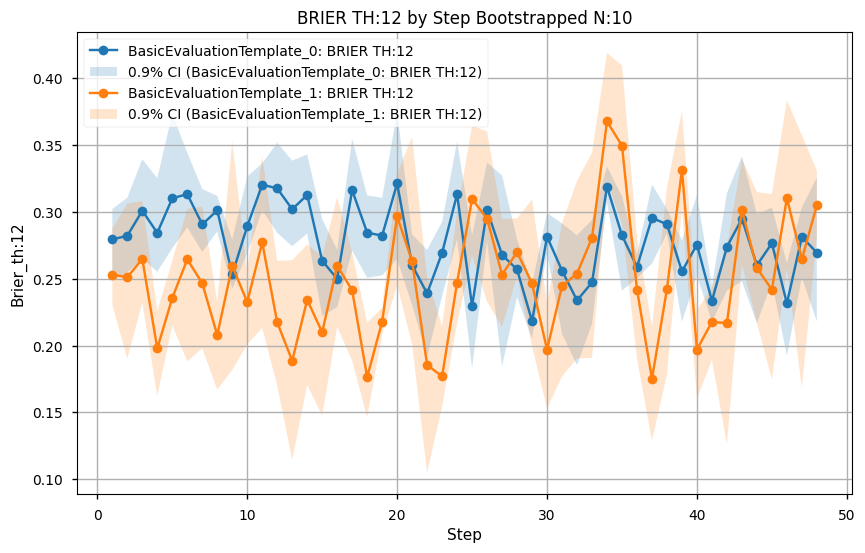

In [8]:
pfceval.plotting.plot_lead_time_metrics(*reports, table_name="unseen_bootstraped_lead_time_metrics", metrics=["crps", "mse", "brier_th:12"])

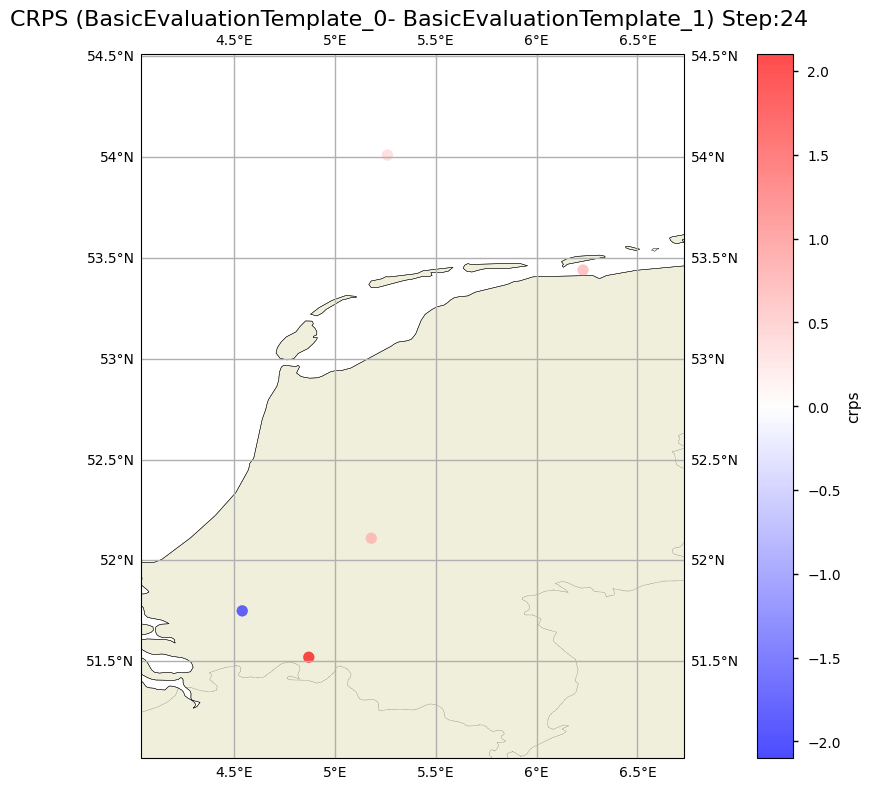

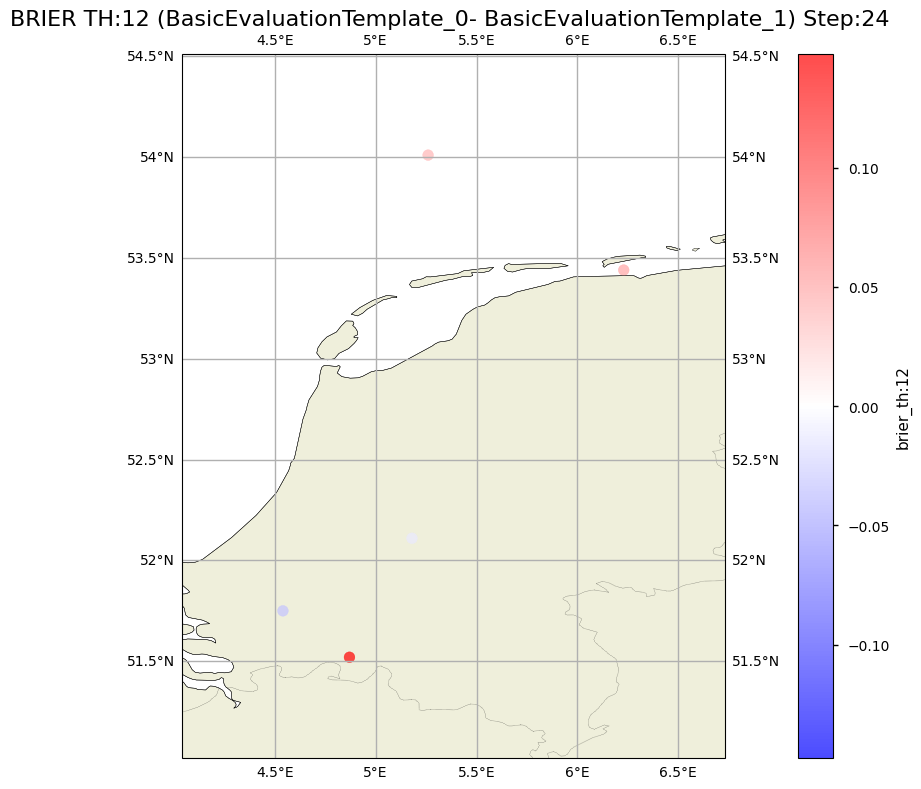

In [9]:
pfceval.plotting.plot_location_metrics(
    step=24, 
    evaluation=reports[0], 
    compare_with=reports[1], 
    metrics=["crps", "brier_th:12"], 
    cmap="bwr", 
    dot_size=60, 
    tol=0.5,
)

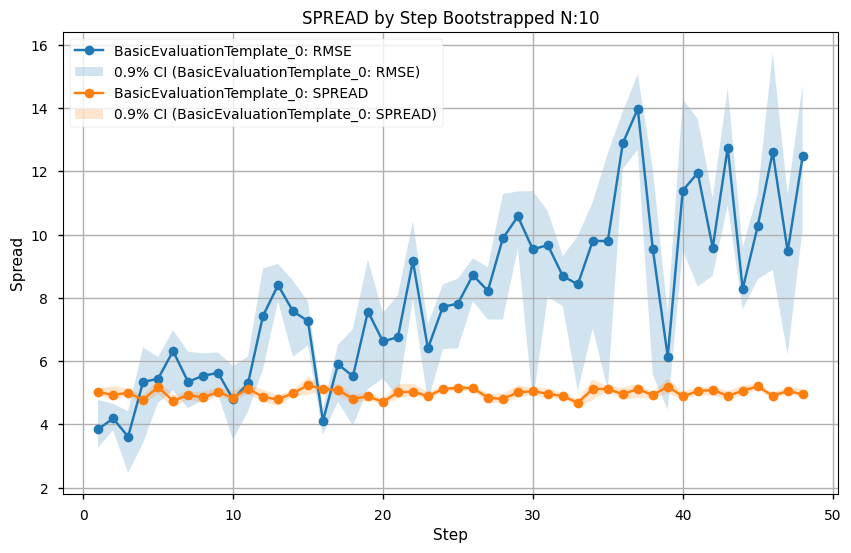

In [10]:
pfceval.plotting.plot_spread_rmse(reports[0], table_name="unseen_bootstraped_lead_time_metrics")

In [11]:
reports[0].tables()

['overall_metrics',
 'lead_time_metrics',
 'lead_time_location_metrics',
 'station_meta',
 'bootstraped_lead_time_metrics',
 'seen_overall_metrics',
 'seen_lead_time_metrics',
 'seen_lead_time_location_metrics',
 'seen_station_meta',
 'seen_bootstraped_lead_time_metrics',
 'unseen_overall_metrics',
 'unseen_lead_time_metrics',
 'unseen_lead_time_location_metrics',
 'unseen_station_meta',
 'unseen_bootstraped_lead_time_metrics']

In [12]:
reports[0]["unseen_bootstraped_lead_time_metrics"]

{'values': shape: (48, 25)
 ┌───────────┬───────────┬───────────┬───────────┬───┬───────────┬───────────┬───────────┬──────────┐
 │ step      ┆ brier_th: ┆ brier_th: ┆ brier_th: ┆ … ┆ twcrps_th ┆ twcrps_th ┆ twcrps_th ┆ twcrps_t │
 │ ---       ┆ 12_mean   ┆ 12_q005   ┆ 12_q095   ┆   ┆ :12_q095  ┆ :9_mean   ┆ :9_q005   ┆ h:9_q095 │
 │ duration[ ┆ ---       ┆ ---       ┆ ---       ┆   ┆ ---       ┆ ---       ┆ ---       ┆ ---      │
 │ μs]       ┆ f64       ┆ f64       ┆ f64       ┆   ┆ f64       ┆ f64       ┆ f64       ┆ f64      │
 ╞═══════════╪═══════════╪═══════════╪═══════════╪═══╪═══════════╪═══════════╪═══════════╪══════════╡
 │ 1h        ┆ 0.279253  ┆ 0.24845   ┆ 0.30196   ┆ … ┆ 0.976799  ┆ 1.778049  ┆ 1.631729  ┆ 2.010783 │
 │ 2h        ┆ 0.28199   ┆ 0.25472   ┆ 0.3104    ┆ … ┆ 0.937976  ┆ 1.655157  ┆ 1.495232  ┆ 1.815363 │
 │ 3h        ┆ 0.300692  ┆ 0.26495   ┆ 0.33915   ┆ … ┆ 1.127162  ┆ 1.78992   ┆ 1.615002  ┆ 1.930632 │
 │ 4h        ┆ 0.284168  ┆ 0.25505   ┆ 0.325     ┆ … ┆ 